核心流程說明
只對 selected_attack = "UDP" 子集做處理

篩出所有 Label 為 "UDP" 的 flow。

只計算一種熵：Shannon 熵

每筆流（8 維整數向量）當作「離散分布」，呼叫 calc_shannon_entropy，得到 H_shannon。

如果 flow 全部值一樣或是空陣列，就直接回傳 0.0，避免除以零或其他警告。

二群分群 (Binary Clustering)

把 UDP 流量的 H_shannon 當作一維特徵輸入 KMeans，n_clusters=2 → 產生兩個 cluster label：0、1。

為了好看，把 0、1 分別映射成 "A"、"B"，存在 LocalLabel 欄裡。

若該伺服器上的 UDP 流量不足 2 筆，就會把 n_clusters 調整成 1（直接全部歸成 A），以免 KMeans 跑不過去。

產生「正樣本」 vs 「補集」檔案

對於每個 local label：

正樣本 (df_pos)：只保留 LocalLabel == lbl（例如群 A）。

補集 (df_comp)：保留 LocalLabel != lbl。

分別輸出成 parquet：

UDP_LocalA_positive.parquet

UDP_LocalA_complement.parquet

UDP_LocalB_positive.parquet

UDP_LocalB_complement.parquet

這樣就能把每個群的正負例單獨傳回中央。



| 攻擊類型        | 推薦熵度量           | 原因簡述                                                                                        |
| ----------- | --------------- | ------------------------------------------------------------------------------------------- |
| **LDAP**    | **Rényi (α=2)** | LDAP 掃描常呈現「某幾個目標 IP/Port 被大量查詢」的現象，Rényi (α=2) 對高頻率事件特別敏感，能快速識別「集中度極高」的流量模式。                |
| **MSSQL**   | **Shannon**     | MSSQL 掃描/攻擊通常包含較多變化（不同查詢字串、不同欄位、大量隨機封包），Shannon 熵對全域不確定性（多種模式混合）把握較好。                       |
| **NetBIOS** | **Min Entropy** | NetBIOS 掃描常因為「單一或少數目標佔絕大多數請求」，Min 熵（只看最大機率事件）即可一槍捕捉「哪個主機被集中轟炸」。                             |
| **Portmap** | **Min Entropy** | Portmap（RPC Port Mapper）又常見「針對某幾個特定 port（111/tcp 等）大量探測」，Min 熵專注在最常出現的特徵，最能看出「這個 port 被刷爆」。 |
| **Syn**     | **Rényi (α=2)** | SYN Flood 通常來自有限幾個巨量來源（如僞造的同一組 IP），Rényi (α=2) 可放大「來源集中化」的異常比率，比 Shannon 更敏感。               |
| **UDP**     | **Shannon**     | UDP Flood 流量可能分散在多個端口、不同目標（VoIP、DNS、NTP 等檔案），Shannon 熵能同時考量多種分佈變化，對「整體混亂度」把握較佳。             |
| **UDPLag**  | **Rényi (α=2)** | UDPLag（一種 UDP 漏洞放大攻擊）通常在少數放大伺服器間爆量，Rényi (α=2) 對放大源/目標高度集中有更強的檢測靈敏度。                        |
| **DNS**     | **Shannon**     | DNS 放大攻擊常見大量查詢多個子域、回應異常分散，Shannon 熵可同時反映「查詢路徑多樣」與「回應分佈異常」，綜合偵測能力最佳。                         |
| **NTP**     | **Min Entropy** | NTP 放大攻擊集中在 NTP monlist 查詢，幾乎都是同一個訊息模式，Min 熵能直接指出「哪個最常見訊息被濫用」，快速觸發告警。                       |
| **SNMP**    | **Min Entropy** | SNMP 掃描/放大也是「固定 OID 查詢」頻率極高，Min 熵抓「最常出現那筆 OID」的跳動，就能一眼抓到異常。                                 |
| **TFTP**    | **Shannon**     | TFTP 放大可能結合多個檔案名稱、不同傳輸參數，Shannon 熵對多種小波動更靈敏，能綜合評估「小量多樣」的掃描/攻擊。                              |


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from scipy.stats import entropy as shannon_entropy
from rich.console import Console
from rich.table import Table

# PySwarms PSO 套件
import pyswarms as ps

console = Console()

# ==== 將三種熵函式都收集到一起 ====
def compute_shannon(row: np.ndarray) -> float:
    """
    row: 一維整數陣列，代表一筆 flow 的所有特徵值
    回傳這筆資料的 Shannon Entropy (以 base=2)。
    """
    vals, counts = np.unique(row, return_counts=True)
    probs = counts / counts.sum()
    return float(shannon_entropy(probs, base=2))


def compute_renyi(row: np.ndarray, alpha: float = 2.0) -> float:
    """
    計算 Renyi Entropy:
      H_α = 1/(1 - α) * log2( Σ_i p_i^α )
    alpha=2 是常見選擇，若希望其他 α，可修改呼叫時參數。
    """
    if alpha == 1.0:
        return compute_shannon(row)
    vals, counts = np.unique(row, return_counts=True)
    probs = counts / counts.sum()
    sum_p_alpha = np.sum(probs ** alpha)
    return float(1.0 / (1.0 - alpha) * np.log2(sum_p_alpha))


def compute_min_entropy(row: np.ndarray) -> float:
    """
    Min-Entropy (H_∞) = -log2( max_i p_i )。
    """
    vals, counts = np.unique(row, return_counts=True)
    probs = counts / counts.sum()
    max_p = np.max(probs)
    return float(-np.log2(max_p))


# ==== attack_dict 決定每種攻擊對應哪種熵 ====
# 這裡依照先前邏輯預設：某些攻擊用 Renyi、某些用 Min、其餘用 Shannon
attack_dict = {
    "LDAP":    "renyi",
    "MSSQL":   "shannon",
    "NetBIOS": "min",
    "Portmap": "min",
    "Syn":     "renyi",
    "UDP":     "shannon",
    "UDPLag":  "renyi",
    "DNS":     "shannon",
    "NTP":     "min",
    "SNMP":    "min",
    "TFTP":    "shannon",
}


# ==== 使用者參數 ====
selected_attack = "UDP"   # 目前我們把 UDP 當作 A 群 (正類)，你可以改成其他攻擊（如 "LDAP"）
base_path      = "/Users/hungwei/Desktop/Proj/AI_DDOS/data/2019"


# ==== 1. 自動掃描整個 base_path，把所有「*-training.parquet」與「*-testing.parquet」都讀進來 ====
pattern_train = os.path.join(base_path, "*-training.parquet")
pattern_test  = os.path.join(base_path, "*-testing.parquet")
all_train_fps = glob.glob(pattern_train)
all_test_fps  = glob.glob(pattern_test)

# 如果一個都找不到就報錯
if len(all_train_fps) + len(all_test_fps) == 0:
    raise FileNotFoundError(f"在路徑 {base_path} 下未找到任何 '-training.parquet' 或 '-testing.parquet' 檔案！")

console.print(f"[bold cyan]掃描到 {len(all_train_fps)} 個 training.parquet、{len(all_test_fps)} 個 testing.parquet，準備讀取…[/]")

# 讀所有檔並合併
dfs = []
for fp in all_train_fps + all_test_fps:
    # 直接用 pandas 讀取 parquet
    try:
        df_tmp = pd.read_parquet(fp)
        # 取出檔名來取得攻擊名稱：例如 "UDP-training.parquet" → selected_attack="UDP"
        basename = os.path.basename(fp)
        attack_name = basename.split("-")[0]  # 以「-」切，以第一段當作攻擊名字
        df_tmp['OriginalLabel'] = attack_name  # 新增一欄註明這筆資料原本屬於哪個攻擊
        dfs.append(df_tmp)
    except Exception as e:
        console.print(f"[bold red]讀取 {fp} 時失敗：{e}[/]")
        continue

# 完成合併
df_all = pd.concat(dfs, ignore_index=True)
console.print(f"[bold green]成功合併所有 parquet 檔，總筆數：{len(df_all)}[/]")


# ==== 2. 清理 & 統一 Label ====
df_all.columns = df_all.columns.str.strip()

# 原本 parquet 裡 Label 欄可能已經是攻擊 or "Benign"，
# 但我們要統一：只要「OriginalLabel == selected_attack」，就標為正類(selected_attack)；
# 否則都視為其他攻擊或 Benign，一律歸到 "Other" (當作 A 補數)。
# 如果 parquet 本身 Label 欄不存在，則用 OriginalLabel 直接判斷即可。

if 'Label' in df_all.columns:
    # 先把所有 Label 欄裡非 "Benign" 的值都視為它原本的攻擊
    df_all['Label'] = df_all['Label'].apply(lambda x: x if x == "Benign" else x.strip())
else:
    # 如果真的沒有 Label 欄，就把 OriginalLabel 裡的 benign/parsing?
    # 假設 parquet 裡都有原始攻擊寫在 OriginalLabel，Benign 可能在 Label 裡或另有說明，這邊先兜個保險：
    df_all['Label'] = df_all['OriginalLabel']

# 現在把「selected_attack」與「其他 (攻擊 或 Benign)」區分成二分類
df_all['BinaryLabel'] = df_all['Label'].apply(
    lambda x: selected_attack if x == selected_attack else "Other"
)

# 顯示一下 BinaryLabel 分布
label_counts = df_all['BinaryLabel'].value_counts()
total_count  = len(df_all)
console.print("\n[bold cyan]=== BinaryLabel 分布 (A vs A 補數) ===[/]")
for lbl, cnt in label_counts.items():
    pct = cnt / total_count * 100
    name = "A (UDP)" if lbl == selected_attack else "A 補數 (Other)"
    console.print(f"[yellow]{name:<12}[/]: {cnt} 筆 ({pct:.2f}%)")
console.print(f"[bold]總筆數：{total_count}[/]")


# ==== 3. 衍生特徵 (與之前一樣) ====
df_all['PSH Flags Ratio']          = df_all['Fwd PSH Flags'] / (df_all['Bwd PSH Flags'] + 1e-6)
df_all['Flow Packets/Bytes Ratio'] = df_all['Flow Packets/s'] / (df_all['Flow Bytes/s'] + 1e-6)
df_all['Total Packets']            = df_all['Total Fwd Packets'] + df_all['Total Backward Packets']
df_all['Active-Idle Mean Diff']    = df_all['Active Mean'] - df_all['Idle Mean']

selected_features = [
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/Bytes Ratio",
    "Total Packets",
    "Flow IAT Mean",
    "PSH Flags Ratio",
    "Active-Idle Mean Diff"
]

# 如果有 NA 全補 0，並轉整數
df_all[selected_features] = df_all[selected_features].fillna(0).astype(int)


# ==== 4. 根據 attack_dict 決定用哪種熵 ====
# 這裡 method 直接用 selected_attack 的對應值 (UDP → "shannon")，其他攻擊都套這個 method
method = attack_dict.get(selected_attack, "shannon").lower()
if method not in {"shannon", "renyi", "min"}:
    raise ValueError(f"Unknown entropy method '{method}' for attack '{selected_attack}'.")

console.print(f"\n[bold green]目前選擇的熵計算方式：{method.capitalize()} Entropy（因為 selected_attack = {selected_attack}）[/]")


# ==== 5. 計算滾動窗口熵 (每 window_size 筆 flow 為一組) ====
window_size   = 100
entropy_vals  = []
num_rows      = len(df_all)

console.print(f"\n[bold green]開始以 rolling window 計算 {method.capitalize()} 熵（每 {window_size} 筆 flow 為一組）…[/]")

for start in range(0, num_rows, window_size):
    end = min(start + window_size, num_rows)
    window = df_all.iloc[start:end][selected_features].values.astype(int)

    window_entropies = []
    for row in window:
        if method == "shannon":
            H = compute_shannon(row)
        elif method == "renyi":
            # 預設 alpha=2，如果想改 alpha，只要在這裡指定
            H = compute_renyi(row, alpha=2.0)
        else:  # "min"
            H = compute_min_entropy(row)
        window_entropies.append(H)

    avg_entropy = float(np.mean(window_entropies))
    # 把同一組 window 的平均熵重複填回去
    entropy_vals.extend([avg_entropy] * (end - start))

# 把結果寫回 DataFrame
df_all['H_entropy'] = entropy_vals
console.print(f"[bold green]所有 {method.capitalize()} 熵計算完成！共計 {len(entropy_vals)} 筆。[/]")


# ==== 6. 把 H_entropy 和 BinaryLabel 轉成 numpy array，準備 PSO 成本函式使用 ====
H_values_np = df_all['H_entropy'].values.reshape(-1, 1)   # shape = (N, 1)
Labels_np   = df_all['BinaryLabel'].values               # shape = (N, )
N_total     = H_values_np.shape[0]


# ==== 7. PSO 參數設定 ====
n_particles = 500     # 粒子數量
max_iters   = 500    # PSO 最大迭代次數

# H_entropy 的搜尋範圍上下界就是整個資料的 min ~ max
h_min = df_all['H_entropy'].min()
h_max = df_all['H_entropy'].max()
bounds = (np.array([h_min, h_min]), np.array([h_max, h_max]))  # 兩維都相同上下界

options = {
    'c1': 0.5,  # 個人經驗係數
    'c2': 0.3,  # 社群經驗係數
    'w':  0.9   # 慣性權重
}


# ==== 8. 定義成本函式 cost_function ====
def cost_function(x):
    """
    x: shape = (n_particles, 2)，每一列代表一組 [c1, c2] 為兩個 centroid
    群 A (c1) 希望都是 UDP；群 A 補數 (c2) 希望都是 Other。
    回傳 shape=(n_particles,) 的 cost array：每個粒子的誤分類數。
    """
    n_p   = x.shape[0]
    costs = np.zeros((n_p,))

    for i in range(n_p):
        c1, c2 = x[i, 0], x[i, 1]
        dist_to_c1 = np.abs(H_values_np.flatten() - c1)
        dist_to_c2 = np.abs(H_values_np.flatten() - c2)
        assign_to_A = dist_to_c1 <= dist_to_c2  # True → 分到 A 群

        # A 群裡面，本來是 Other 的就算誤分；A 補數裡面，本來是 UDP 的也算誤分
        mis_other_in_A = np.sum(Labels_np[assign_to_A] == "Other")
        mis_udp_in_Ac  = np.sum(Labels_np[~assign_to_A] == selected_attack)
        costs[i] = mis_other_in_A + mis_udp_in_Ac

    return costs


# ==== 9. 建立並執行 GlobalBestPSO ====
optimizer = ps.single.GlobalBestPSO(
    n_particles=n_particles,
    dimensions=2,
    options=options,
    bounds=bounds
)

console.print(f"\n[bold green]PSO 開始演化 (迭代次數：{max_iters})…[/]")
best_cost, best_pos = optimizer.optimize(
    cost_function,
    iters=max_iters,
)

c1_opt, c2_opt   = best_pos[0], best_pos[1]
min_misclass     = best_cost

console.print("\n[bold green]PSO 演化完成！[/]")
console.print(f"[bold yellow]最佳 Centroid (c1*, c2*) = [{c1_opt:.5f}, {c2_opt:.5f}][/]")
console.print(f"[bold yellow]最小誤分類樣本數 = {int(min_misclass)}[/]")


# ==== 10. 用最佳 (c1*, c2*) 做最終分群，並把結果回寫回 DataFrame ====
dist_to_c1_opt = np.abs(H_values_np.flatten() - c1_opt)
dist_to_c2_opt = np.abs(H_values_np.flatten() - c2_opt)
assign_to_A_opt = dist_to_c1_opt <= dist_to_c2_opt
df_all['LocalLabel_PSO'] = np.where(assign_to_A_opt, "A", "A 補數")


# ==== 11. 列印最終分群結果：A vs A 補數 的純度分析 ====
label_table = Table(
    title=f"PSO 最終分群 純度分析 [{selected_attack} 作為 A 群] (使用 {method.capitalize()} Entropy)",
    show_lines=True
)
label_table.add_column("LocalLabel", justify="center", style="bold cyan")
label_table.add_column(f"{selected_attack} (UDP) 數量", justify="right")
label_table.add_column("Other (所有其他攻擊或 Benign) 數量", justify="right")
label_table.add_column("誤分樣本數", justify="right")

for lbl in ["A", "A 補數"]:
    group = df_all[df_all['LocalLabel_PSO'] == lbl]
    count_udp   = np.sum(group['BinaryLabel'] == selected_attack)
    count_other = np.sum(group['BinaryLabel'] == "Other")
    # 在 A 群裡面，Other 要算誤分；在 A 補數裡，UDP 要算誤分
    if lbl == "A":
        mis = count_other
    else:
        mis = count_udp 
    label_table.add_row(lbl, str(count_udp), str(count_other), str(int(mis)))

console.print(f"\n[bold magenta]PSO 最終分群結果 (A vs A 補數)：[/]")
console.print(label_table)

if min_misclass == 0
    console.print("[bold green]恭喜！已成功將 A 群完美切成只含 UDP，而 A 補數只含 Other。[/]")
else:
    console.print(f"[bold red]最小誤分類樣本數為 {int(min_misclass)}，無法做到 100% 純度。[/]")

掃描到 7 個 training.parquet、10 個 testing.parquet，準備讀取…

成功合併所有 parquet 檔，總筆數：431371

=== BinaryLabel 分布 (A vs A 補數) ===

A 補數 (Other): 413281 筆 (95.81%)

A (UDP)     : 18090 筆 (4.19%)

總筆數：431371

目前選擇的熵計算方式：Shannon Entropy（因為 selected_attack = UDP）

開始以 rolling window 計算 Shannon 熵（每 100 筆 flow 為一組）…

所有 Shannon 熵計算完成！共計 431371 筆。

PSO 開始演化 (迭代次數：500)…

2025-06-01 22:55:28,112 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=18190.0
2025-06-01 23:17:50,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18190.0, best pos: [2.00830855 2.00909144]


PSO 演化完成！

最佳 Centroid (c1*, c2*) = [2.00831, 2.00909]

最小誤分類樣本數 = 18190

PSO 最終分群結果 (A vs A 補數)：

          PSO 最終分群 純度分析 [UDP 作為 A 群] (使用 Shannon Entropy)           
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ LocalLabel ┃ UDP (UDP) 數量 ┃ Other (所有其他攻擊或 Benign) 數量 ┃ 誤分樣本數 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│     A      │              0 │                                100 │        100 │
├────────────┼────────────────┼────────────────────────────────────┼────────────┤
│   A 補數   │          18090 │                             413181 │      18090 │
└────────────┴────────────────┴────────────────────────────────────┴────────────┘

最小誤分類樣本數為 18190，無法做到 100% 純度。

In [17]:
# 5.1 用 best_pos 做一次最終分群
c1_opt, c2_opt = best_pos[0], best_pos[1]
dist_to_c1_opt = np.abs(H_values.flatten() - c1_opt)
dist_to_c2_opt = np.abs(H_values.flatten() - c2_opt)
assign_to_c1_opt = dist_to_c1_opt <= dist_to_c2_opt

# 用新的 LocalLabel 欄位標示「A (對應 cluster=0)」或「A 補數 (cluster=1)」
sub['LocalLabel_PSO'] = np.where(assign_to_c1_opt, "A", "A 補數")

# 5.2 顯示 A / A 補數 兩群中 DDoS vs Benign 的分佈
label_table = Table(title="PSO 最終分群 純度分析 (A vs A 補數)", show_lines=True)
label_table.add_column("LocalLabel", justify="center", style="bold cyan")
label_table.add_column("DDoS (UDP) 數量", justify="right")
label_table.add_column("Benign 數量", justify="right")
label_table.add_column("DDoS 百分比", justify="right")

for lbl in ["A", "A 補數"]:
    group = sub[sub['LocalLabel_PSO'] == lbl]
    count_ddos = np.sum(group['Label'] == selected_attack)
    count_benign = np.sum(group['Label'] == 'Benign')
    total = len(group)
    percent_ddos = (count_ddos / total) * 100 if total > 0 else 0.0
    label_table.add_row(lbl, str(count_ddos), str(count_benign), f"{percent_ddos:.2f}%")

console.print("\n[bold magenta]PSO 最終分群：UDP vs Benign 在 A / A 補數 兩群的分佈：[/]")
console.print(label_table)


PSO 最終分群：UDP vs Benign 在 A / A 補數 兩群的分佈：

            PSO 最終分群 純度分析 (A vs A 補數)             
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ LocalLabel ┃ DDoS (UDP) 數量 ┃ Benign 數量 ┃ DDoS 百分比 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     A      │           14700 │         500 │      96.71% │
├────────────┼─────────────────┼─────────────┼─────────────┤
│   A 補數   │              92 │        4375 │       2.06% │
└────────────┴─────────────────┴─────────────┴─────────────┘

# use Xgboost

In [18]:
import os
import numpy as np
import pandas as pd
from scipy.stats import entropy as shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from rich.console import Console
from rich.table import Table

console = Console()

# ==== 使用者參數 ====
selected_attack = "UDP"
base_path = '/Users/hungwei/Desktop/Proj/AI_DDOS/data/2019'

# ==== 找 parquet 檔案 ====
train_fp = os.path.join(base_path, f"{selected_attack}-training.parquet")
test_fp  = os.path.join(base_path, f"{selected_attack}-testing.parquet")
file_paths = [p for p in (train_fp, test_fp) if os.path.isfile(p)]
if not file_paths:
    raise FileNotFoundError(f"No parquet files for attack '{selected_attack}' in {base_path}")

# ==== 讀資料並合併 ====
dfs = [pd.read_parquet(fp) for fp in file_paths]
df = pd.concat(dfs, ignore_index=True)

# ==== 清理 & 篩選 Label ====
df.columns = df.columns.str.strip()
if 'Label' in df.columns:
    df = df[df['Label'].isin([selected_attack, "Benign"])].copy()
    df['Label'] = df['Label'].apply(lambda x: 1 if x == selected_attack else 0)
    # 這裡把 UDP 對應成 1 (DDoS)，Benign 對應成 0 (正常)

# ==== 顯示 Label 分布 ====
label_counts = df['Label'].value_counts()
total_count = len(df)
console.print("\n[bold cyan]標籤分布統計：[/]")
console.print(f"[yellow]DDoS (1)[/]: {label_counts.get(1, 0)} 筆 ({(label_counts.get(1,0)/total_count)*100:.2f}%)")
console.print(f"[yellow]Benign (0)[/]: {label_counts.get(0, 0)} 筆 ({(label_counts.get(0,0)/total_count)*100:.2f}%)")
console.print(f"[bold]總資料筆數：{total_count}[/]")

# ==== 衍生特徵 ====
df['PSH Flags Ratio']          = df['Fwd PSH Flags'] / (df['Bwd PSH Flags'] + 1e-6)
df['Flow Packets/Bytes Ratio'] = df['Flow Packets/s'] / (df['Flow Bytes/s'] + 1e-6)
df['Total Packets']            = df['Total Fwd Packets'] + df['Total Backward Packets']
df['Active-Idle Mean Diff']    = df['Active Mean'] - df['Idle Mean']

# 這些就是我們覺得可能對分類有用的欄位
selected_features = [
    "Protocol",
    "Flow Duration",
    "Flow Bytes/s",
    "Flow Packets/Bytes Ratio",
    "Total Packets",
    "Flow IAT Mean",
    "PSH Flags Ratio",
    "Active-Idle Mean Diff"
]

# 先把 NaN 填 0，再全部轉成 int
df[selected_features] = df[selected_features].fillna(0).astype(int)

# ==== 計算 Shannon 熵 (rolling window) ====
# 方法跟之前一樣：每 100 筆 flow 看一次這 8 維特徵的 row-wise 熵，取平均
sub = df.copy()  # 包含 UDP + Benign
window_size = 100
entropy_vals = []

console.print("\n[bold green]開始以 rolling window 計算 Shannon 熵（每 100 筆 flow 為一組）…[/]")
for start in range(0, len(sub), window_size):
    end = min(start + window_size, len(sub))
    window = sub.iloc[start:end][selected_features].values.astype(int)

    window_entropies = []
    for row in window:
        vals, counts = np.unique(row, return_counts=True)
        probs = counts / counts.sum()
        H = shannon_entropy(probs, base=2)
        window_entropies.append(H)

    avg_entropy = float(np.mean(window_entropies))
    entropy_vals.extend([avg_entropy] * (end - start))

sub['H_shannon'] = entropy_vals
console.print("[bold green]所有 Shannon 熵 (window_size=100) 計算完畢！[/]")

# 現在 sub DataFrame 有：selected_features + H_shannon + Label(0/1)
# 我們可以把它當成特徵矩陣和標籤，直接丟到 XGBoost 去訓練


# ==== 準備 X 與 y ====
features_for_model = selected_features + ["H_shannon"]
X = sub[features_for_model].values   # shape = (N, 9)
y = sub['Label'].values              # shape = (N,)

# 切分：80% 訓練，20% 測試；並且隨機 seed 固定，確保結果可重現
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

console.print(f"\n[bold green]訓練集: {len(y_train)} 筆，測試集: {len(y_test)} 筆[/]")


# ==== 訓練 XGBoost Classifier ====
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,       # 總共 100 顆樹，視資料量也能調大或調小
    max_depth=6,            # 樹的深度
    learning_rate=0.1,      # 學速 (eta)
    subsample=0.8,          # 80% 的資料隨機抽樣去建樹，避免 overfitting
    colsample_bytree=0.8,   # 每棵樹只用 80% 的特徵
    random_state=42,
    n_jobs=-1               # 多核心跑
)

console.print("\n[bold green]開始訓練 XGBoost Classifier…[/]")
model.fit(X_train, y_train)
console.print("[bold green]XGBoost 訓練完成！[/]")


標籤分布統計：

DDoS (1): 14792 筆 (75.21%)

Benign (0): 4875 筆 (24.79%)

總資料筆數：19667

開始以 rolling window 計算 Shannon 熵（每 100 筆 flow 為一組）…

所有 Shannon 熵 (window_size=100) 計算完畢！

訓練集: 15733 筆，測試集: 3934 筆

開始訓練 XGBoost Classifier…

/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost 訓練完成！

測試集 Accuracy: 100.00%

Classification Report (Precision/Recall/F1):

precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       975
        DDoS       1.00      1.00      1.00      2959

    accuracy                           1.00      3934
   macro avg       1.00      1.00      1.00      3934
weighted avg       1.00      1.00      1.00      3934

           Confusion Matrix           
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Pred\True  ┃ Benign (0) ┃ DDoS (1) ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━┩
│ Benign (0) │    975     │    0     │
├────────────┼────────────┼──────────┤
│  DDoS (1)  │     0      │   2959   │
└────────────┴────────────┴──────────┘

前五重要特徵（依照 'weight'）

feature  importance
     f8       169.0
     f2       159.0
     f1        91.0
     f5        79.0
     f0        66.0

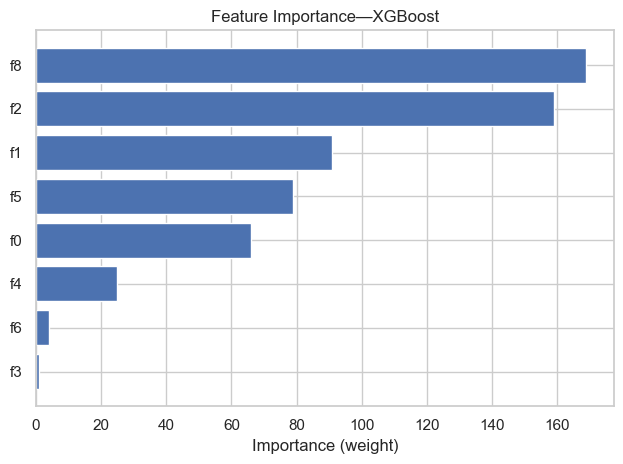

In [20]:
# ==== 在測試集上做預測 ====
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 如果想看機率分數，可以用這條

# ==== 準確率 & 分類報告 ====
acc = accuracy_score(y_test, y_pred)
console.print(f"\n[bold cyan]測試集 Accuracy: {acc*100:.2f}%[/]")

console.print("\n[bold magenta]Classification Report (Precision/Recall/F1):[/]")
report = classification_report(y_test, y_pred, target_names=["Benign", "DDoS"])
console.print(report)

# ==== 混淆矩陣 ====
cm = confusion_matrix(y_test, y_pred)
table_cm = Table(title="Confusion Matrix", show_lines=True)
table_cm.add_column("Pred\\True", justify="center")
table_cm.add_column("Benign (0)", justify="center")
table_cm.add_column("DDoS (1)", justify="center")
table_cm.add_row("Benign (0)", str(cm[0,0]), str(cm[0,1]))
table_cm.add_row("DDoS (1)",   str(cm[1,0]), str(cm[1,1]))
console.print(table_cm)

# ==== 取得特徵重要性 ====
import matplotlib.pyplot as plt

# 這會回傳一個 dict: {feature_name: importance_score, ...}
importance_dict = model.get_booster().get_score(importance_type='weight')

# 將它轉成 DataFrame，方便排序
fi_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values(by='importance', ascending=False)

# 用 rich 或 matplotlib 簡單印一下前五名
console.print("\n[bold cyan]前五重要特徵（依照 'weight'）[/]")
console.print(fi_df.head(5).to_string(index=False))

# 如果你想畫 bar chart（可選）
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel("Importance (weight)")
plt.title("Feature Importance—XGBoost")
plt.gca().invert_yaxis()  # 讓最重要的在最上面
plt.tight_layout()
plt.show()
